In [1]:
import torch
import torchvision
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split, ConcatDataset, Subset
from collections import Counter
import copy
import random
import math

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [2]:
LEARNING_RATE = 0.01
NUM_CLIENTS = 5
LOCAL_ROUNDS = 10
GLOBAL_ROUNDS = 10
ALPHA = 0.1
SAMPLE_FRACTIONS = [0.5, 1]
BATCH_SIZE = 64
SEED_NUM = 47

torch.manual_seed(SEED_NUM)
random.seed(SEED_NUM)
np.random.seed(SEED_NUM)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED_NUM)

In [3]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # self.input_layer = nn.Conv2d(3,16,4,stride = 1)
        self.hidden_layer = nn.Sequential(
            nn.Conv2d(3,32,3,stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(32,64,3,stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Conv2d(64,256,3,stride = 1, padding = 1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(4096,512),
            nn.ReLU(),
            nn.Linear(512,10),
        )

    def forward(self, x):
        x = self.hidden_layer(x)
        return x

In [4]:
def state_dict_to_vector(state_dict):
    return torch.cat([v.flatten().cpu() for v in state_dict.values()])

def fed_avg(global_model, train_loaders, device, sample_fraction=1.0, lr=LEARNING_RATE):
    """
    Performs a single round of Federated Averaging (FedAvg).
    """
    criterion = nn.CrossEntropyLoss()
    num_clients = len(train_loaders)

    # 1. Client Selection
    n_clients = max(1, int(math.ceil(sample_fraction * num_clients)))
    selected_indices = sorted(random.sample(range(num_clients), n_clients))
    selected_loaders = [train_loaders[i] for i in selected_indices]

    global_model.to(device)
    global_state = {k: v.detach().cpu().clone() for k, v in global_model.state_dict().items()}
    global_vec = state_dict_to_vector(global_state)

    # Calculate total data points of participating clients for weighted averaging
    participating_data = sum(len(loader.dataset) for loader in selected_loaders)

    # Accumulator for the weighted average of model deltas
    global_param_update = [torch.zeros_like(p.data) for p in global_model.parameters()]
    per_client_drifts = []

    # --- Each selected client trains locally ---
    for client_idx, loader in zip(selected_indices, selected_loaders):
        local_model = copy.deepcopy(global_model).to(device)
        optimizer = optim.SGD(local_model.parameters(), lr=lr)
        local_model.train()

        # --- Standard FedAvg Local Training Loop ---
        # (This loop uses the global LOCAL_ROUNDS variable from your script)
        for _ in range(LOCAL_ROUNDS):
            for images, labels in loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = local_model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

        # --- Compute updates and drift ---
        local_state = local_model.state_dict()
        local_vec = state_dict_to_vector(local_state)
        drift_norm = torch.norm(local_vec - global_vec, p=2).item()
        per_client_drifts.append(drift_norm)

        Ni = len(loader.dataset) # Number of data points for this client

        # Δw_i = w_i - w (model delta)
        delta_w_i = [p_local.data - p_global.data
                     for p_local, p_global in zip(local_model.parameters(), global_model.parameters())]

        # Accumulate the weighted model delta
        with torch.no_grad():
            for g_param, delta_w in zip(global_param_update, delta_w_i):
                # Weight by (Ni / N_total_participating)
                g_param += (Ni / participating_data) * delta_w

    # --- Server updates global model ---
    # The global update is the sum of the weighted deltas
    with torch.no_grad():
        for param, delta in zip(global_model.parameters(), global_param_update):
            param.data += delta

    avg_drift = float(np.mean(per_client_drifts))
    return avg_drift

def fed_scaffold(global_model, train_loaders, device, c_global, c_local,
                 sample_fraction=1.0, lr=LEARNING_RATE):
    criterion = nn.CrossEntropyLoss()
    num_clients = len(train_loaders)

    n_clients = max(1, int(math.ceil(sample_fraction * num_clients)))
    selected_indices = sorted(random.sample(range(num_clients), n_clients))
    selected_loaders = [train_loaders[i] for i in selected_indices]

    global_model.to(device)
    global_state = {k: v.detach().cpu().clone() for k, v in global_model.state_dict().items()}
    global_vec = state_dict_to_vector(global_state)

    participating_data = sum(len(loader.dataset) for loader in selected_loaders)

    global_param_update = [torch.zeros_like(p.data) for p in global_model.parameters()]
    delta_c_global = [torch.zeros_like(p.data) for p in global_model.parameters()]
    per_client_drifts = []

    # --- Each selected client trains locally with SCAFFOLD correction ---
    for client_idx, loader in zip(selected_indices, selected_loaders):
        local_model = copy.deepcopy(global_model).to(device)
        optimizer = optim.SGD(local_model.parameters(), lr=lr)
        local_model.train()

        c_local_i = c_local[client_idx]
        
        num_local_steps = 0  # <-- NEW: Counter for actual steps

        for _ in range(LOCAL_ROUNDS):
            for images, labels in loader:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = local_model(images)
                loss = criterion(outputs, labels)
                loss.backward()

                # SCAFFOLD correction term: grad += (c_local_i - c_global)
                with torch.no_grad():
                    for param, c_g, c_l in zip(local_model.parameters(), c_global, c_local_i):
                        if param.grad is None:
                            continue
                        cg = c_g.to(param.grad.device).type_as(param.grad)
                        cl = c_l.to(param.grad.device).type_as(param.grad)
                        param.grad.add_(cl - cg)

                optimizer.step()
                num_local_steps += 1  # <-- NEW: Increment step counter

        # --- Compute updates ---
        local_state = local_model.state_dict()
        local_vec = state_dict_to_vector(local_state)
        drift_norm = torch.norm(local_vec - global_vec, p=2).item()
        per_client_drifts.append(drift_norm)

        Ni = len(loader.dataset)

        # Δw_i = w_i - w
        delta_w_i = [p_local.data - p_global.data
                     for p_local, p_global in zip(local_model.parameters(), global_model.parameters())]

        # Update global parameter accumulator (weighted)
        with torch.no_grad():
            for g_param, delta_w in zip(global_param_update, delta_w_i):
                g_param += (Ni / participating_data) * delta_w

        # --- Update client control variate ---
        # c_i_new = c_i - c_global + (1 / (K * lr)) * Δw_i  (where K is total steps)
        old_c_i = [t.clone() for t in c_local_i]
        
        # <-- CHANGED: Check for steps to avoid division by zero
        if num_local_steps > 0:
            with torch.no_grad():
                new_c_i = []
                # <-- CHANGED: Use num_local_steps instead of LOCAL_ROUNDS
                denominator = num_local_steps * lr 
                # denominator = LOCAL_ROUNDS*lr
                for c_i, c_g, delta_w in zip(c_local_i, c_global, delta_w_i):
                    # This is the line you fixed, with the correct denominator
                    new_c_i.append(c_i - c_g + (delta_w / denominator))
                c_local[client_idx] = new_c_i
        else:
            # If client had no data, control variate doesn't change
            c_local[client_idx] = old_c_i


        # --- Accumulate c_global updates ---
        with torch.no_grad():
            for dc, old_c, new_c in zip(delta_c_global, old_c_i, c_local[client_idx]):
                dc += (Ni / participating_data) * (new_c - old_c)

    # --- Server updates global model ---
    with torch.no_grad():
        for param, delta in zip(global_model.parameters(), global_param_update):
            param.data += delta

    # --- Server updates c_global ---
    with torch.no_grad():
        for c_g, dc in zip(c_global, delta_c_global):
            c_g += dc

    avg_drift = float(np.mean(per_client_drifts))
    return avg_drift


In [5]:
def evaluate(model, test_loader, device):
  model.eval()
  correct, total, test_loss = 0, 0, 0
  criterion = nn.CrossEntropyLoss()
  with torch.no_grad():
      for images, labels in test_loader:
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          loss = criterion(outputs, labels)
          test_loss += loss.item() * images.size(0)
          _, predicted = torch.max(outputs, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
  return test_loss / total, 100 * correct / total

In [6]:
# !pip install fedlab

In [7]:
from fedlab.utils.dataset.partition import CIFAR10Partitioner

heter_loaders = []

transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
  ])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE)

hetero_dir_part = CIFAR10Partitioner(train_dataset.targets,
                                    NUM_CLIENTS,
                                    balance=None,
                                    partition="dirichlet",
                                    dir_alpha=ALPHA,
                                    seed=SEED_NUM)

heter_loaders = [
    DataLoader(Subset(train_dataset, hetero_dir_part.client_dict[i]), batch_size=BATCH_SIZE, shuffle=True)
    for i in range(NUM_CLIENTS)
]

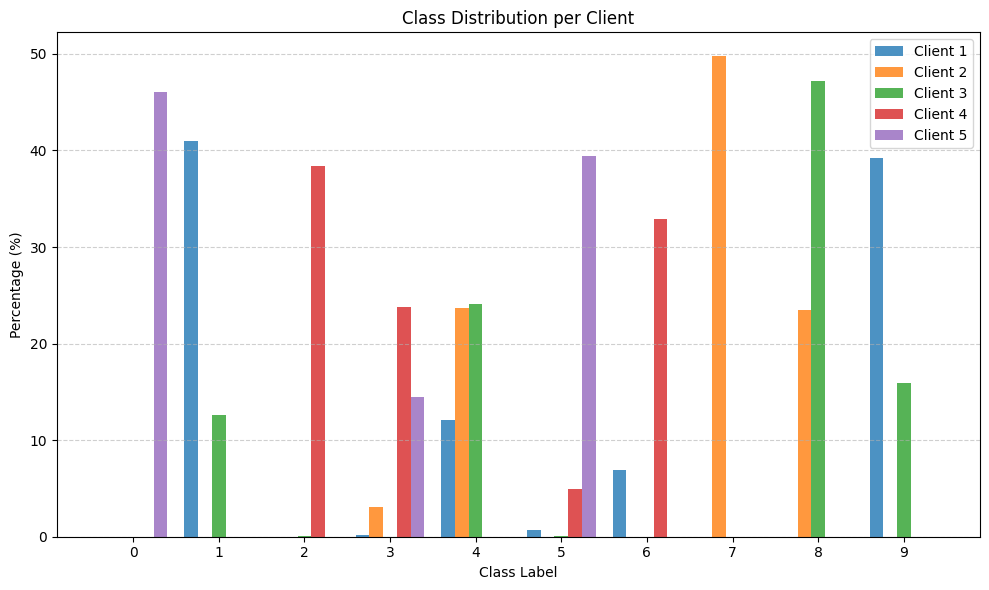

In [8]:

def plot_class_distributions(train_loaders, num_classes=10):
    class_dists = []

    # compute class percentage for each client
    for loader in train_loaders:
        if hasattr(loader.dataset, 'targets'):
            labels = loader.dataset.targets
        elif hasattr(loader.dataset, 'labels'):
            labels = loader.dataset.labels
        else:
            labels = []
            for _, y in loader:
                labels.extend(y.tolist())
            labels = torch.tensor(labels)

        counts = Counter(labels.tolist())
        total = sum(counts.values())
        percents = [counts.get(c, 0) / total * 100 for c in range(num_classes)]
        class_dists.append(percents)

    # plot
    class_labels = np.arange(num_classes)
    width = 0.8 / len(train_loaders)  # to fit all clients side-by-side

    plt.figure(figsize=(10, 6))
    for i, dist in enumerate(class_dists):
        plt.bar(class_labels + i * width, dist, width=width, label=f'Client {i+1}', alpha=0.8)

    plt.xticks(class_labels + width*(len(train_loaders)/2 - 0.5), [str(i) for i in range(num_classes)])
    plt.xlabel("Class Label")
    plt.ylabel("Percentage (%)")
    plt.title("Class Distribution per Client")
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

plot_class_distributions(heter_loaders, num_classes=10)

In [9]:
clients = [0,1,2,3,4]
client_train_loaders = heter_loaders

In [10]:
accuracies_fedav = {}
drifts_fedav = {}
accuracies_scaf = {}
drifts_scaf = {}
for sample in SAMPLE_FRACTIONS:
    fedav_global_model = SimpleCNN()
    fedav_global_model.to(device)
    scaf_global_model = SimpleCNN()
    scaf_global_model.to(device)
    c_global = [torch.zeros_like(p.data, device=device).detach() for p in scaf_global_model.parameters()]
    c_local  = {i: [torch.zeros_like(p.data, device=device).detach() for p in scaf_global_model.parameters()] for i in clients}
    accuracies_fedav[sample] = []
    drifts_fedav[sample] = []
    accuracies_scaf[sample] = []
    drifts_scaf[sample] = []
    print(f"\n SAMPLE FRACTION = {sample}")
    for round in range(GLOBAL_ROUNDS):
        print(f"Round {round+1}:")
        fedav_drift = fed_avg(fedav_global_model, client_train_loaders, device, sample_fraction=sample)
        drifts_fedav[sample].append(fedav_drift)
        fedav_loss, fedav_acc = evaluate(fedav_global_model, test_loader, device)
        accuracies_fedav[sample].append(fedav_acc)
        print(f"    FedAVG: Test Loss: {fedav_loss:.4f}, Test Acc: {fedav_acc:.2f}%, Avg Drift: {fedav_drift:.4f}")
        scaf_drift = fed_scaffold(scaf_global_model, client_train_loaders, device, c_global, c_local, sample_fraction=sample)
        drifts_scaf[sample].append(scaf_drift)
        scaf_loss, scaf_acc = evaluate(scaf_global_model, test_loader, device)
        accuracies_scaf[sample].append(scaf_acc)
        print(f"    FedSCAFFOLD: Test Loss: {scaf_loss:.4f}, Test Acc: {scaf_acc:.2f}%, Avg Drift: {scaf_drift:.4f}")
    


 SAMPLE FRACTION = 0.5
Round 1:
    FedAVG: Test Loss: 3.7475, Test Acc: 11.23%, Avg Drift: 2.0511
    FedSCAFFOLD: Test Loss: 3.3022, Test Acc: 13.27%, Avg Drift: 2.1369
Round 2:
    FedAVG: Test Loss: 3.0884, Test Acc: 13.20%, Avg Drift: 1.8708
    FedSCAFFOLD: Test Loss: 3.4168, Test Acc: 23.26%, Avg Drift: 1.8259
Round 3:
    FedAVG: Test Loss: 2.4398, Test Acc: 27.64%, Avg Drift: 1.7150
    FedSCAFFOLD: Test Loss: 2.5589, Test Acc: 33.67%, Avg Drift: 1.9392
Round 4:
    FedAVG: Test Loss: 3.1653, Test Acc: 21.43%, Avg Drift: 1.4318
    FedSCAFFOLD: Test Loss: 2.0929, Test Acc: 41.77%, Avg Drift: 1.8507
Round 5:
    FedAVG: Test Loss: 2.8132, Test Acc: 28.33%, Avg Drift: 1.5447
    FedSCAFFOLD: Test Loss: 1.9951, Test Acc: 42.65%, Avg Drift: 1.7595
Round 6:
    FedAVG: Test Loss: 2.6498, Test Acc: 33.41%, Avg Drift: 1.5654
    FedSCAFFOLD: Test Loss: 1.6887, Test Acc: 46.86%, Avg Drift: 1.7268
Round 7:
    FedAVG: Test Loss: 4.0333, Test Acc: 28.61%, Avg Drift: 1.3880
    FedSCAFF

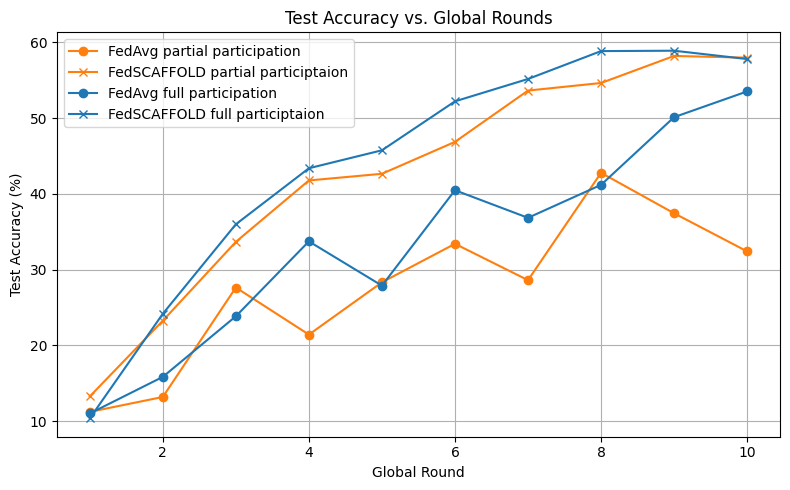

In [14]:
rounds = list(range(1, 11))

# --- Plot 1: Accuracy ---
plt.figure(figsize=(8,5))
plt.plot(rounds, accuracies_fedav[0.5], marker='o', color='tab:orange', label='FedAvg partial participation')
plt.plot(rounds, accuracies_scaf[0.5], marker='x', color='tab:orange', label='FedSCAFFOLD partial participtaion')
plt.plot(rounds, accuracies_fedav[1], marker='o', color='tab:blue', label='FedAvg full participation')
plt.plot(rounds, accuracies_scaf[1], marker='x', color='tab:blue', label='FedSCAFFOLD full participtaion')
plt.title('Test Accuracy vs. Global Rounds')
plt.xlabel('Global Round')
plt.ylabel('Test Accuracy (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

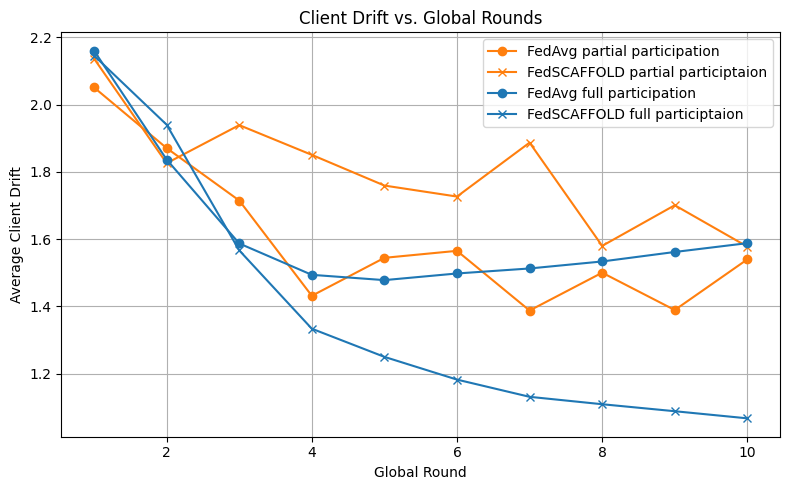

In [15]:
plt.figure(figsize=(8,5))
plt.plot(rounds, drifts_fedav[0.5], marker='o', color='tab:orange', label='FedAvg partial participation')
plt.plot(rounds, drifts_scaf[0.5], marker='x', color='tab:orange', label='FedSCAFFOLD partial participtaion')
plt.plot(rounds, drifts_fedav[1], marker='o', color='tab:blue', label='FedAvg full participation')
plt.plot(rounds, drifts_scaf[1], marker='x', color='tab:blue', label='FedSCAFFOLD full participtaion')
plt.title('Client Drift vs. Global Rounds')
plt.xlabel('Global Round')
plt.ylabel('Average Client Drift')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
import pickle

# Save the dictionary to a pickle file
with open("accuracies_scaf.pkl", "wb") as f: # "wb" for write binary
    pickle.dump(accuracies_scaf, f)

# To load the dictionary back from the pickle file
with open("accuracies_scaf.pkl", "rb") as f: # "rb" for read binary
    loaded_dict = pickle.load(f)

print(loaded_dict)

{0.5: [13.27, 23.26, 33.67, 41.77, 42.65, 46.86, 53.63, 54.63, 58.2, 57.97], 1: [10.38, 24.18, 35.99, 43.38, 45.75, 52.21, 55.16, 58.84, 58.89, 57.79]}
